In [2]:
import os
import numpy as np
import pandas as pd
from astropy.timeseries import LombScargle
import matplotlib.pyplot as plt
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
from astropy import units as u
from gatspy.periodic import LombScargleFast
from astroquery.jplhorizons import Horizons

In [109]:
#####-----CONSTANTS/stuff to check-----#####

beta = 0.059   # standard value of phase slope by which to correct apparent mags
real_period = 12.4041/24. # hours
phase_to_real_period = False
limiting_rh = 0.  # Value of rh beyond which to accept data points (minimise possibility of activity)
obj = '90000696'

In [110]:
# read in lightcurve data
home_path = os.path.expanduser('~/')
path_67p = home_path+'Documents/year1/shape_modelling/67p/'
file = path_67p+'67P_LCs_R.dat'
#####-----Remember to remove square brackets from file!!!!-----#####
data = pd.read_table(file, sep=' ')
data_table = data.to_numpy()

col_names = []
for col in data:
    col_names.append(col)
print('Column names for table:')
print(', '.join(col_names))

Column names for table:
mjd, mag, m_app, rh, delta, alpha, unc


In [111]:
# Read in LSST uncertainties from colours:
colour_uncs = []
func = open(path_67p+'LSST_uncertainties_from_colours.txt', 'r')
lines = func.readlines()
for line in lines:
    data = line.split()
    colour_uncs.append(float(data[0]))

In [112]:
# Rename necessary columns to their respective column names:
mjd = data_table[:,0]
og_mag = data_table[:,1]
app_mag = data_table[:,2]
rh = data_table[:,3]
delta = data_table[:,4]
alpha = data_table[:,5]
#unc = data_table[:,-1]
unc = colour_uncs

In [113]:
# Now treating the lightcurve points as if they are real, apparent magnitudes obtained observationally
# Will correct for distance and for standard phase function with slope beta=0.04

# Absolute magnitude correction:

def convertToH0(m,b,a,r,d):
    H_r = m - (b*a) - (5.0*np.log10(r*d))
    return H_r

In [114]:
# Generate list of absolutely corrected magnitudes:
# Account here for minimum distance to the sun
magsPeriod = []; mjdPeriod = []; uncPeriod = []; rhPeriod=[]

for i in range(len(app_mag)):
    if (rh[i]>=limiting_rh):
        magsPeriod.append(convertToH0(app_mag[i], beta, alpha[i], rh[i], delta[i]))
        mjdPeriod.append(mjd[i])
        uncPeriod.append(unc[i])
        rhPeriod.append(rh[i])
magsPeriod=np.array(magsPeriod)
npoints = len(magsPeriod)
print('No. values at heliocentric distance >%.1fau is %i out of possible %i'%(limiting_rh, npoints, len(app_mag)))
# Rescale points in mjdPeriod to=0
mjdPeriod = np.array(mjdPeriod)#-mjdPeriod[0]

No. values at heliocentric distance >0.0au is 678 out of possible 678


In [115]:
#t_days = np.array(mjdPeriod)#*u.day
#mags = magsPeriod#*u.mag
#mags_unc = uncPeriod#*u.mag
print(app_mag)

[22.4525 22.2301 22.3996 22.2278 22.2812 22.2812 22.18   22.1797 22.1829
 22.1842 22.3275 22.2619 21.9915 22.0286 22.0141 22.2049 22.1177 22.1094
 22.0934 22.0923 22.1365 22.2138 22.2911 22.2729 21.8714 21.8737 21.8779
 21.922  21.9526 21.9515 21.8942 21.8924 22.1616 22.1636 22.1585 22.1577
 21.9689 21.9356 22.0446 22.0085 21.7993 21.7165 21.7787 21.8846 21.9364
 21.8907 21.8597 21.5507 21.5949 21.7967 21.7587 21.6996 21.643  21.6416
 21.6064 21.6035 21.5407 21.5354 21.4758 21.429  21.4719 21.4305 21.4298
 21.3745 21.4924 21.4941 21.4241 21.3375 21.4577 21.4199 21.4067 21.3728
 21.5127 21.5478 21.2931 21.2536 21.3733 21.573  21.5369 21.4694 21.4372
 21.5946 21.5645 21.6927 21.6893 21.4755 21.4282 21.7618 21.8109 22.7963
 22.7671 22.8059 22.8101 22.8478 22.86   22.8436 22.9351 22.8578 22.7462
 22.7259 23.4267 23.3842 23.3602 23.3657 23.32   23.418  23.1097 23.2647
 23.226  23.2652 23.1212 23.1    23.0643 23.0626 23.06   22.9679 23.0305
 22.9583 23.0197 22.8877 22.9594 22.9583 22.9458 22

In [116]:
#uncPeriod=np.array(uncPeriod)*0.5

In [117]:
# Import perihelion time for 67P
peri_mjd = []
comet = Horizons(id=obj, location='500@0', epochs=mjdPeriod[0])
els = comet.elements(refplane='earth')
peri_mjd.append(float(els['Tp_jd']))
per = float(els['P'])
print(peri_mjd, per/365.)

[2459519.123335867] 6.4696429042223045


In [118]:
# Find next point one orbital period along to draw lines on the plot

mjd_newepoch = mjdPeriod[0]+per

for i in range(len(mjdPeriod)):
    if mjdPeriod[i]>=mjd_newepoch:
        index_newepoch = i
        break

In [119]:
comet = Horizons(id=obj, location='500@0', epochs=mjdPeriod[index_newepoch])
els = comet.elements(refplane='earth')
peri_mjd.append(float(els['Tp_jd']))
print(peri_mjd)

[2459519.123335867, 2461872.249238884]


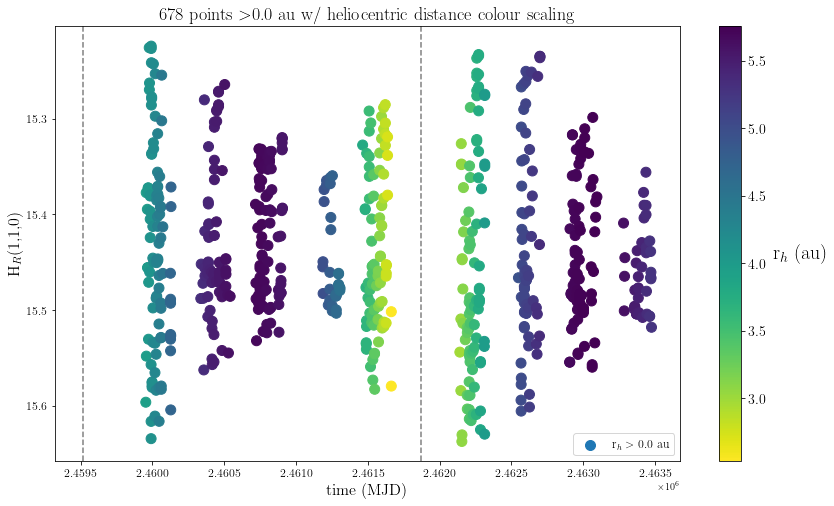

In [120]:
# Have a look at data
labels=16; ticks=12; titles=18
plt.figure(figsize=(14,8))
for apparition in peri_mjd:
    v = plt.axvline(apparition, linestyle='--', color='grey')
plt.scatter(mjdPeriod, magsPeriod, c=rhPeriod, cmap='viridis_r', s=100, label='r$_h >$ %.1f au'%(limiting_rh))
#plt.errorbar(mjdPeriod, magsPeriod, yerr=uncPeriod, fmt='.',ecolor='rhPeriod')
plt.xlabel('time (MJD)', fontsize=labels)
plt.ylabel('H$_R$(1,1,0)', fontsize=labels)
plt.xticks(fontsize=ticks)
plt.yticks(fontsize=ticks)
plt.gca().invert_yaxis()

# Set colourbar to be actually readable and useful
cbar = plt.colorbar()#ticks = [3.6, 4.0, 4.5, 5.0, 5.5])
cbar.set_label(r' r$_h$ (au)', rotation=0,  labelpad=35, fontsize=20)
cbar.ax.tick_params(labelsize=14)
#cbar.ax.set_yticklabels(['3.6', '4.0', '4.5', '5.0', '5.5'])
plt.title(r"%s points \textgreater %.1f au w/ heliocentric distance colour scaling"%(str(npoints), limiting_rh), fontsize=titles)
plt.legend(loc=4, fontsize=ticks)
plt.show()
#plt.savefig(datadir+'paper_pics/'+'')
#fig, ax = plt.subplots(figsize=(16, 6))
#ax.errorbar(mjdPeriod, magsPeriod, uncPeriod, fmt='.k', ecolor='gray', capsize=0)
#ax.set(xlabel='time (MJD)', ylabel='magnitude', title='67P LSST magnitudes')
#ax.invert_yaxis()

In [121]:
# period range to sample:

min_prot=0.1#*u.day # days
max_prot=2.#*u.day # days
Nsample = 100000
# Define frequency range:
freq = np.linspace(1./max_prot, 1./min_prot, Nsample)

In [122]:
 # Astropy periodogram implementation:
power_ap = LombScargle(mjdPeriod, magsPeriod, uncPeriod).power(freq, method='fast')

best_frequency_ap = freq[np.argmax(power_ap)]
best_period_ap = 1./best_frequency_ap
print("Best period (astropy) = {0:.6f}h".format((best_period_ap)*24.))
periods_ap = 1./freq

Best period (astropy) = 12.390394h


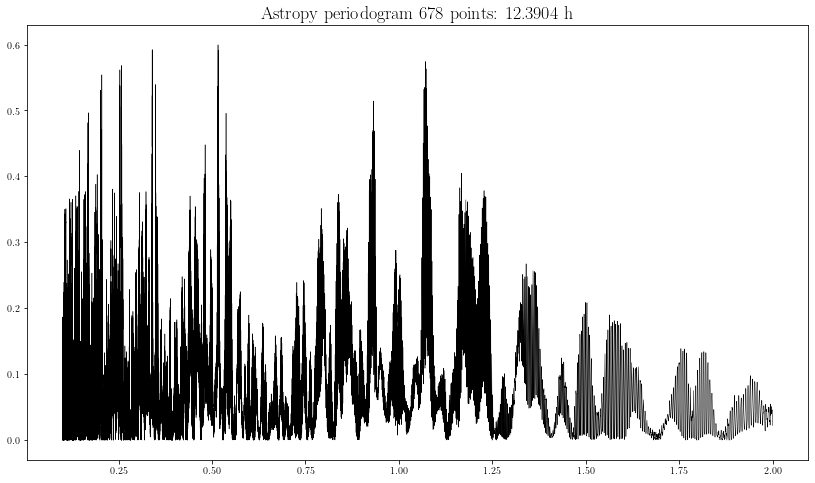

In [123]:
plt.figure(figsize=(14,8))
plt.plot(periods_ap, power_ap,color='k',linewidth=0.5)
plt.title('Astropy periodogram %i points: %.4f h'%(npoints, (best_period_ap)*24.),fontsize=titles)

plt.show()

In [124]:
# Phase the data to the best period
multiplier = 1.

In [125]:
if phase_to_real_period==True:
    final_period_ap = real_period
    phase_ap = mjdPeriod/final_period_ap % 1
    print('Using real period %.4f'%(final_period_ap*24.))
else:
    final_period_ap = multiplier*best_period_ap
    phase_ap = mjdPeriod/final_period_ap % 1
    print('Phase to %.1fx best-fit LS (astropy) period %.4fh'%(multiplier, best_period_ap*24.))

Phase to 1.0x best-fit LS (astropy) period 12.3904h


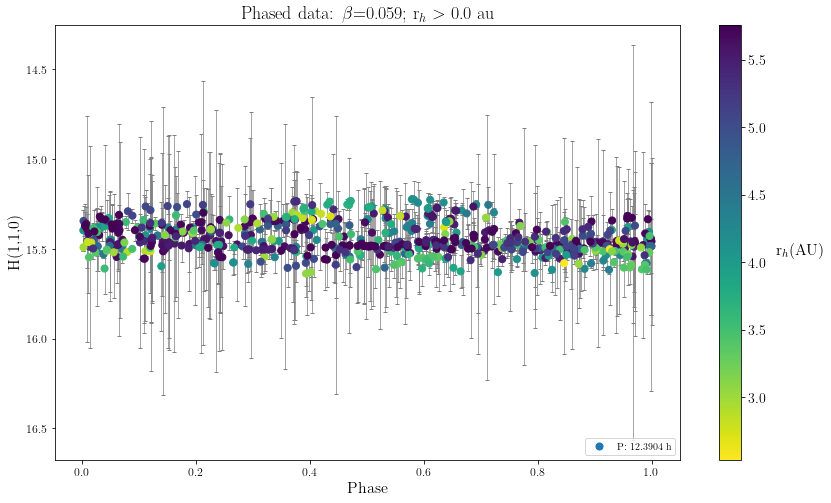

In [132]:
#fig, ax = plt.subplots(1, 2, figsize=(16, 6))
#ax[0].plot(periods_ap, power_ap)
#ax[0].set(xlabel='Period (days)', ylabel='Lomb-Scargle Power (AP)', title='Lomb-Scargle Periodogram (AP)')

#ax[1].errorbar(phase_ap, magsPeriod, uncPeriod, fmt='.k', ecolor='gray', capsize=0, label='P: %.4f h'%(multiplier*24.*best_period_ap))
#ax[1].set(xlabel='phase', ylabel='magnitude', title='Phased Data (AP)')
#ax[1].invert_yaxis()
#ax[1].legend(loc=4)
#plt.show()

plt.figure(figsize=(14,8))
plt.scatter(phase_ap, magsPeriod, c=rhPeriod, cmap='viridis_r', s=50, label='P: %.4f h'%(24.*final_period_ap), zorder=2)
plt.errorbar(phase_ap, magsPeriod, yerr=uncPeriod, fmt=".", color="gray", elinewidth=0.7,capsize=2, zorder=1)
plt.xlabel('Phase', fontsize=labels);plt.ylabel('H(1,1,0)', fontsize=labels)
plt.xticks(fontsize=ticks); plt.yticks(fontsize=ticks)
cbar = plt.colorbar()#ticks = [3.6, 4.0, 4.5, 5.0, 5.5])
cbar.set_label('r$_h$(AU)', labelpad=35, rotation=0, fontsize=labels)
cbar.ax.tick_params(labelsize=14)
plt.gca().invert_yaxis()
plt.title('Phased data: '+r'$\beta$=%.3f; r$_h >$ %.1f au'%(beta,limiting_rh), fontsize=titles)
plt.legend(loc=4)
#plt.set(xlabel='phase', ylabel='magnitude', title='Phased Data')
plt.show()

In [22]:
# Trialling different periodogram methods:
#  i) gatspy LombScargleFast
# ii) Astropy

In [ ]:
#weird_points = []
#for i,val in enumerate(magsPeriod):
#    if val>15.77 and 0.45<phase_gp[i]<0.7:
#        print(val, phase_gp[i], mjdPeriod[i],i)
#        weird_points.append(mjdPeriod[i])
#max(weird_points)-min(weird_points)

In [ ]:
# Gatspyperiodogram implementation:

"""
# i)

model_gp = LombScargleFast().fit(t_days, mags)
model_gp.optimizer.set(period_range=(min_prot,max_prot))
best_period_gp = model_gp.best_period
print("Best period (gatspy) = {0:.6f}h".format((best_period_gp)*24.))

periods_gp = np.linspace(min_prot, max_prot, Nsample)
power_gp = model_gp.periodogram(periods_gp)

#index_max_gp = np.where(power_gp==max(power_gp))
print(periods_gp[np.argmax(power_gp)]*24.)

plt.figure(figsize=(14,7))
plt.plot(periods_gp, power_gp,color='k',linewidth=0.5)
plt.xticks(fontsize=ticks)
plt.yticks(fontsize=ticks)
plt.xlabel('Period (d)', fontsize=labels)
plt.ylabel('LS power', fontsize=labels)
plt.title('Gatspy periodogram %i LC points: %.4f h'%(npoints, best_period_gp*24.), fontsize=titles)
plt.show()

# Phase the data to the best period
multiplier = 1.

if phase_to_real_period==True:
    final_period_gp = real_period
    phase_gp = t_days/final_period_gp % 1
    print('Using real period %.4f'%(real_period*24.))
else:
    final_period_gp = multiplier*best_period_gp
    phase_gp = t_days/final_period_gp % 1
    print('Phase to %.1fx best-fit LS (gatspy) period %.4f h'%(multiplier, best_period_gp*24.))
    
#fig, ax = plt.subplots(1, 2, figsize=(16, 6))
#ax[0].plot(periods_gp, power_gp)
#ax[0].set(xlabel='Period (days)', ylabel='Lomb-Scargle Power', title='Lomb-Scargle Periodogram')

#ax[1].errorbar(phase_gp, magsPeriod, uncPeriod, fmt='.k', ecolor='gray', capsize=0, label='P: %.4f h'%(real_period*24.))#multiplier*24.*best_period_gp))
#ax[1].set(xlabel='phase', ylabel='magnitude', title='Phased Data')
#ax[1].invert_yaxis()
#ax[1].legend(loc=4)
#plt.show()

plt.figure(figsize=(14,8))
plt.scatter(phase_gp, magsPeriod, c=rhPeriod, cmap='viridis_r', s=50, label='P: %.4f h'%(24.*final_period_gp), zorder=2)
#plt.errorbar(phase_gp, magsPeriod, yerr=mags_unc, fmt=".", color="gray", elinewidth=0.7,capsize=2, zorder=1)
plt.xlabel('Rotational phase', fontsize=labels);plt.ylabel('H$_R$(1,1,0)', fontsize=labels)
plt.xticks(fontsize=ticks); plt.yticks(fontsize=ticks)
cbar = plt.colorbar()#ticks = [3.6, 4.0, 4.5, 5.0, 5.5])
#cbar.set_label('r$_h$(AU)', rotation=0, labelpad=35, fontsize=20)
cbar.ax.tick_params(labelsize=14)
plt.title('Phased data (GP): r$_h >$ %.1f au'%limiting_rh, fontsize=titles)
plt.gca().invert_yaxis()
plt.legend(loc=4)
#plt.set(xlabel='phase', ylabel='magnitude', title='Phased Data')
plt.show()
#plt.savefig(data_dir+'paper_pics/'+'phased_lc_rh_%s_gp_P_%.4f_colorMJD.png'%(str(limiting_rh), 24.*final_period_gp), format='png', dpi=200)
""";



In [19]:
aspect_angles = []
afile = open(data_dir+'67p_aspect_326.dat')
lines = afile.readlines()
for line in lines:
    aspect_angles.append(float(line))

In [20]:
mikko_file=open(data_dir+'67P_LC_NU.dat')
lcmikko = []
lines=mikko_file.readlines()
for line in lines:
    data = line.split()
    lcmikko.append(float(data[0]))
counter = 0
mjd_aspect=[];rh_aspect=[]
for i,val in enumerate(lcmikko):
    if len(str(val))<=3:
        counter = counter+1
        #print(lcmikko[i+1],counter)
        date_to_add = lcmikko[i+1]
        mjd_aspect.append(date_to_add)
        print(date_to_add)
        for j in range(len(mjd)):
            if mjd[j]==date_to_add:
                rh_aspect.append(rh[j])
                print('yee')
                #print(date_to_add)


2459953.840467
yee
2459956.844791
yee
2459957.799644
yee
2459964.820003
yee
2459966.849076
yee
2459970.80805
yee
2459972.797099
2459973.855214
2459977.817678
yee
2459978.808516
yee
2459979.844439
yee
2459980.778005
2459984.742117
yee
2459990.817626
yee
2459991.754955
yee
2459992.816256
yee
2459994.812072
yee
2459997.770978
yee
2460002.809682
yee
2460003.805077
yee
2460006.703052
yee
2460008.768007
yee
2460009.738086
yee
2460017.724754
yee
2460019.69161
2460025.680273
yee
2460029.668569
yee
2460035.621475
yee
2460036.64978
yee
2460037.656231
yee
2460044.731771
2460045.677312
2460046.641538
yee
2460050.609035
2460055.592053
yee
2460058.590208
yee
2460059.622545
yee
2460061.662309
yee
2460064.598212
yee
2460072.657578
yee
2460125.474148
yee
2460126.429876
2460127.508368
yee
2460129.460292
yee
2460336.845404
yee
2460339.832038
yee
2460351.842981
yee
2460353.859087
2460355.861256
yee
2460357.841048
yee
2460361.846897
yee
2460364.773098
yee
2460365.801812
yee
2460385.782778
yee
2460386.86251

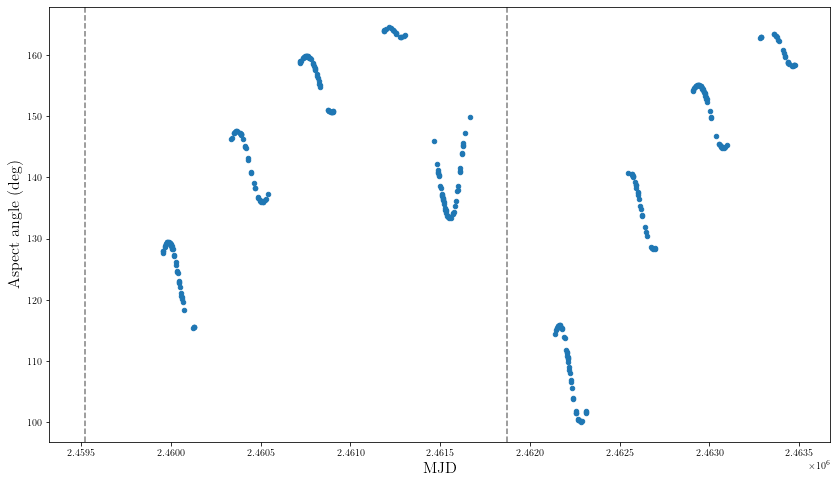

In [21]:
plt.figure(figsize=(14,8))
plt.scatter(mjd_aspect, aspect_angles,s=20)
for apparition in peri_mjd:
    v = plt.axvline(apparition, linestyle='--', color='grey')
plt.xlabel('MJD', fontsize=labels);plt.ylabel('Aspect angle (deg)', fontsize=labels)

plt.show()

In [ ]:
lcmikko[-5:]

In [ ]:
len(rh_aspect)

In [ ]:
mjd

In [ ]:
counter=0
for i in range(len(lcmikko)):
    if lcmikko[i] in mjd:
        counter=counter+1
        print(counter,i, lcmikko[i])

In [22]:
max(rh)

5.755905